# Final project Meteostat

## Members: Dylan Jones and Oscar Coromina Pujol


## Prepare Data

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler
from meteostat import Point, Daily, Hourly, Stations
import torch
import seaborn as sns


In [13]:

lat = 47.6
lon = -122.3

# Define start and end times
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2023, 1, 1)

data = Hourly(Point(lat,lon), start=start, end=end).fetch()

# Find how much data we have
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149017 entries, 2006-01-01 00:00:00 to 2023-01-01 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    149017 non-null  float64
 1   dwpt    149017 non-null  float64
 2   rhum    149017 non-null  float64
 3   prcp    147983 non-null  float64
 4   snow    0 non-null       float64
 5   wdir    146331 non-null  float64
 6   wspd    149017 non-null  float64
 7   wpgt    0 non-null       float64
 8   pres    149014 non-null  float64
 9   tsun    0 non-null       float64
 10  coco    42953 non-null   float64
dtypes: float64(11)
memory usage: 13.6 MB


In [14]:
# Extract all relevant channels and impute and missing values
data_cleaned = data[['temp', 'dwpt', 'pres', 'wdir']]
print(data_cleaned.isna().any())

# Replace NaN values with 0 for 'prcp' feature
# data_cleaned['prcp'].fillna(0, inplace=True)

# Use linear interpolation for other features
data_cleaned['temp'].interpolate(method='linear', inplace=True)
data_cleaned['dwpt'].interpolate(method='linear', inplace=True)
# data_cleaned['wspd'].interpolate(method='linear', inplace=True)
data_cleaned['wdir'].interpolate(method='linear', inplace=True)
data_cleaned['pres'].interpolate(method='linear', inplace=True)

print(data_cleaned.isna().any())


temp    False
dwpt    False
pres     True
wdir     True
dtype: bool
temp    False
dwpt    False
pres    False
wdir    False
dtype: bool


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


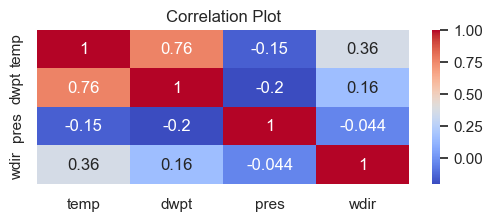

In [15]:
# Generate correlation matrix 
sns.set()
correlation_matrix = data_cleaned.corr()
# first_row = correlation_matrix.iloc[0].to_frame().T
plt.figure(figsize=(6, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

In [16]:
timeseries = data_cleaned.values.astype('float32')

mea=np.mean(timeseries[:,0])
sig=np.std(timeseries[:,0])

scaler = StandardScaler()

scaler.fit(timeseries)

timeseries=scaler.transform(timeseries)

#With this next line (executed) we can include time into the timeseries
#timeseries=np.squeeze(combine_arrays(timeseries,transformed_dates)).astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

num_features=timeseries.shape[1]

num_features

4

In [17]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        features = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(features)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

## Create model and Define Hyperparameters

In [18]:
lookback = 24
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)


In [19]:
class TempModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=num_features, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(50, num_features)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [20]:
model = TempModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=512)
n_epochs = 25


## Identify Tracked Values

In [21]:
train_loss_list = []

## Train

In [22]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_loss_list.append(train_rmse)
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 0.4320, test RMSE 0.4961
Epoch 1: train RMSE 0.4064, test RMSE 0.4751
Epoch 2: train RMSE 0.3972, test RMSE 0.4678
Epoch 3: train RMSE 0.3930, test RMSE 0.4689
Epoch 4: train RMSE 0.3906, test RMSE 0.4649
Epoch 5: train RMSE 0.3890, test RMSE 0.4663
Epoch 6: train RMSE 0.3878, test RMSE 0.4672
Epoch 7: train RMSE 0.3867, test RMSE 0.4697
Epoch 8: train RMSE 0.3857, test RMSE 0.4726
Epoch 9: train RMSE 0.3848, test RMSE 0.4760
Epoch 10: train RMSE 0.3838, test RMSE 0.4769
Epoch 11: train RMSE 0.3830, test RMSE 0.4788
Epoch 12: train RMSE 0.3823, test RMSE 0.4816
Epoch 13: train RMSE 0.3819, test RMSE 0.4806
Epoch 14: train RMSE 0.3814, test RMSE 0.4853
Epoch 15: train RMSE 0.3808, test RMSE 0.4862
Epoch 16: train RMSE 0.3805, test RMSE 0.4846
Epoch 17: train RMSE 0.3803, test RMSE 0.4851
Epoch 18: train RMSE 0.3800, test RMSE 0.4812
Epoch 19: train RMSE 0.3799, test RMSE 0.4902
Epoch 20: train RMSE 0.3794, test RMSE 0.4849
Epoch 21: train RMSE 0.3790, test RMSE 0.486

Text(0.5, 1.0, 'Training Loss')

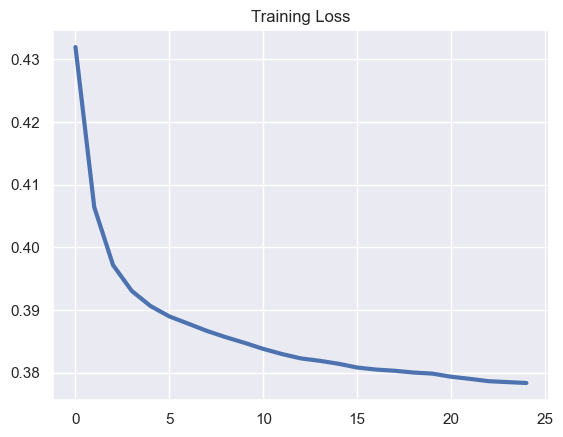

In [30]:
plt.plot(train_loss_list, linewidth = 3)
plt.title("Training Loss")

## Visualize and Evaluate Model

In [24]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

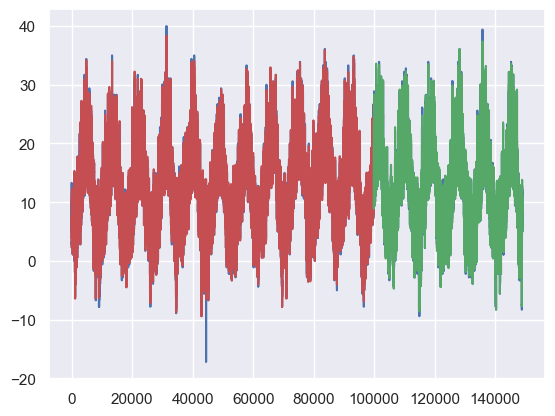

In [25]:
# plot
plt.plot(timeseries[:,0]*sig+mea)
plt.plot(train_plot[:,0]*sig+mea, c='r')
plt.plot(test_plot[:,0]*sig+mea, c='g')
plt.show()

Text(0, 0.5, 'Degrees (C)')

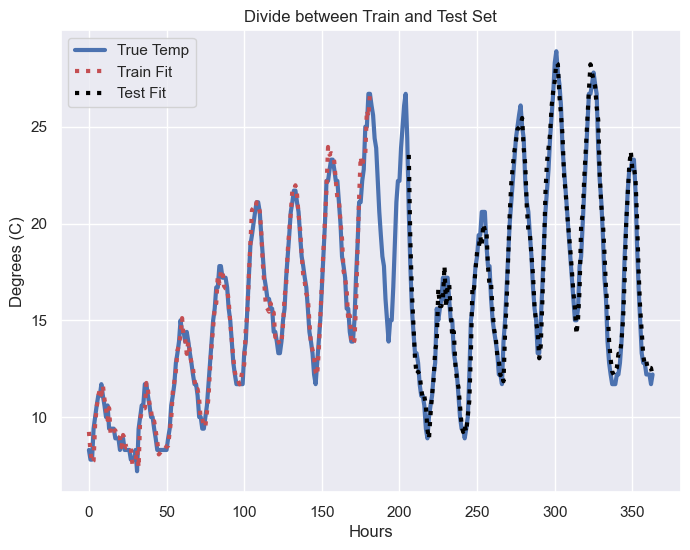

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
# Get data
in_between = timeseries[train_size - (365//2):train_size + (365//2), 0]
ax.plot(in_between*sig+mea, linewidth=3, label='True Temp')
ax.plot(train_plot[train_size - (365//2):train_size + (365//2),0]*sig+mea, c='r', label='Train Fit', linestyle=':', linewidth=3)
ax.plot(test_plot[train_size - (365//2):train_size + (365//2),0]*sig+mea, c='black', label='Test Fit', linestyle=':', linewidth=3)
ax.legend(loc='upper left')
ax.set_title('Divide between Train and Test Set')
ax.set_xlabel('Hours')
ax.set_ylabel('Degrees (C)')


## Predicting n values

In [27]:
n = 12
with torch.no_grad():
    x_test=timeseries[-(lookback+1)*3:-(lookback+1)*2-1]
    xt_test=torch.from_numpy(x_test)
    prediction=model(xt_test)
    totalarray=torch.zeros(lookback+n,num_features)

    totalarray[0:lookback]=xt_test

    for i in range(n):

        froz = int((totalarray == 0).all(dim=1).nonzero(as_tuple=False)[0])

        next_value=model(totalarray[int(froz-lookback):int(froz)])

        totalarray[froz]=next_value[-1]

test_price=totalarray[0:lookback,0].detach().numpy()

price_prediction=totalarray[lookback:-1,0].detach().numpy()

middle=np.array([test_price[-1],price_prediction[0]])


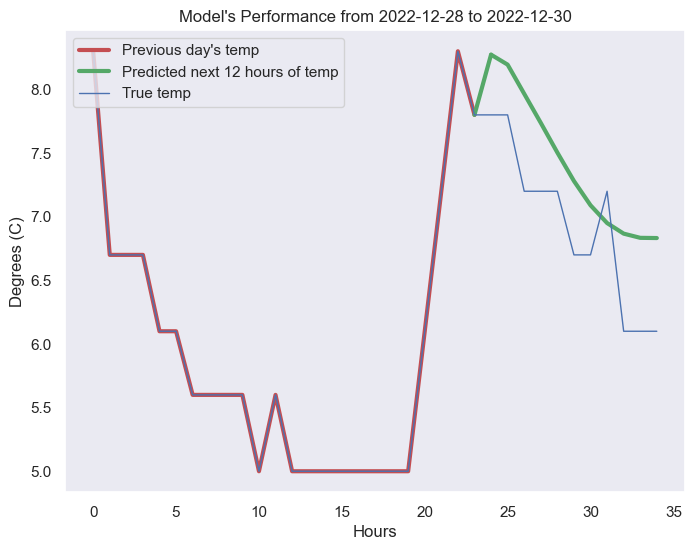

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot((test_price)*sig+mea, c='r', linewidth=3, label="Previous day's temp")
ax.plot(range(lookback-1, lookback + len(middle)-1), (middle)*sig+mea, color='g', linewidth=3, label="Predicted next 12 hours of temp")
ax.plot(range(lookback, lookback + len(price_prediction)), (price_prediction)*sig+mea, color='g', linewidth=3)
ax.plot(mea+sig*timeseries[:,0][-(lookback+1)*3:-40], linewidth=1, label='True temp')
ax.legend(loc='upper left')
ax.set_xlabel('Hours')
ax.set_ylabel('Degrees (C)')
ax.set_title("Model's Performance from 2022-12-28 to 2022-12-30")
ax.grid()